In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import jaccard_score
from scipy.sparse import vstack

Test data provided does not have labels. Use the training data as the original df and perform train_test_split instead

In [2]:
kaggle_train = pd.read_csv('data/train_kaggle.csv')
glue_train = pd.read_csv('data/train_glue.tsv', sep = '\t')
glue_dev = pd.read_csv('data/dev_glue.tsv', sep = '\t')
glue_train = pd.concat([glue_train, glue_dev])

Data cleaning

In [23]:
df = pd.concat([kaggle_train, glue_train])
print('train set dimensions: ', df.shape)
print('\n')


# Remove duplicated data since there might be overlap from 2 different sources
df = df.drop_duplicates(subset = ['question1', 'question2'])
print('train set dimensions after dropping duplicates by question pair: ', df.shape)
print('\n')


# Check for duplicated ID since we are using 2 different sources
df = df.drop_duplicates(subset = ['qid1', 'qid2'])
print('train set dimensions after dropping duplicates by qid pair: ', df.shape)

df = df.drop('id', axis = 1)
df = df.dropna()
X, y = df.drop('is_duplicate', axis = 1), df['is_duplicate']

train set dimensions:  (808566, 6)


train set dimensions after dropping duplicates by question pair:  (404290, 6)


train set dimensions after dropping duplicates by qid pair:  (404290, 6)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42, stratify = y, shuffle = True
)

Distribution of + and - is still acceptable of about 2:3 for +:-

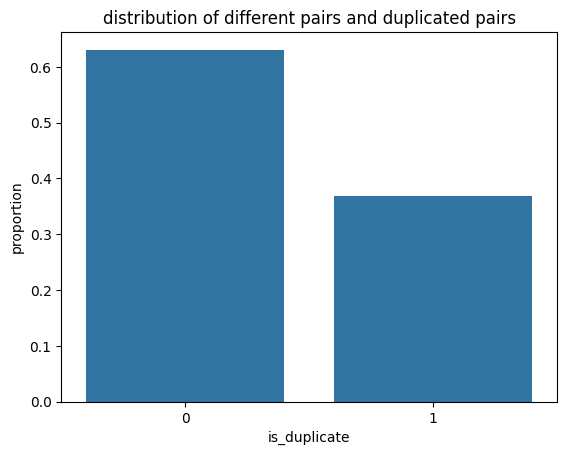

In [5]:
sns.barplot(y_train.value_counts(normalize = True))
plt.title('distribution of different pairs and duplicated pairs')
plt.show()

In [7]:
nlp = spacy.load('en_core_web_sm', exclude = ['parser', 'ner', 'entity_linker', 
                                              'entity_ruler', 'textcat', 'textcat_multilabel', 
                                              'morphologizer', 'senter', 'sentencizer'])
# represents ID tagged to question
id_qn_pair = np.concatenate((X_train[['qid1', 'question1']].values, X_train[['qid2', 'question2']].values))
id_qn_pair = [(qid, nlp(q)) for qid, q in id_qn_pair]

# stores an array of triples qid1, qid2 and label
q1q2_id_label_triple = np.concatenate(
    (X_train[['qid1', 'qid2']].values, 
     y_train.values.reshape(-1, 1)), axis = 1)

In [ ]:
id_qn_lemma_pair = [(qid, [token.lemma_ for token in q if not token.is_stop]) for qid, q in id_qn_pair]
id_mean_qn_token_embedding_pair = [(qid, np.mean([token.vector for token in q], axis = 0)) for qid, q in id_qn_pair]

Find normalized TF-IDF vectors to compute cosine similarity, manhattan distance and euclidean distance

In [ ]:
id_qn_lemma_str_pair = [(qid, ' '.join(lemma_lst)) for qid, lemma_lst in id_qn_lemma_pair]
lemma_str = map(lambda x: x[1], id_qn_lemma_str_pair)

tfidf_vectorizer = TfidfVectorizer()
qn_score_matrix = tfidf_vectorizer.fit_transform(lemma_str)
qn_score_matrix = normalize(qn_score_matrix, norm = 'l2', axis = 1)

qn_id = map(lambda x: x[0], id_qn_lemma_str_pair)
id_to_score_vector = dict(zip(qn_id, qn_score_matrix))

Find presence vector to compute Jaccard distance

In [ ]:
presence_vectorizer = CountVectorizer(binary = True)
lemma_presence_matrix = presence_vectorizer.fit_transform(lemma_str)
id_to_presence_vector = dict(zip(qn_id, lemma_presence_matrix))

In [62]:
id_to_sentence_embedding_pair = dict(id_mean_qn_token_embedding_pair)
id_to_sentence_embedding_pair

{429354: array([ 0.1005709 , -0.3686908 ,  0.15808344,  0.16677412, -0.19804305,
         0.06394409,  0.19707479, -0.05837373, -0.16316777,  0.00643598,
         0.04556084, -0.04361204,  0.07284284,  0.33126742, -0.22212797,
         0.3432003 , -0.18361394,  0.23314068,  0.20837575, -0.18733913,
        -0.06068663,  0.0183277 , -0.1653996 , -0.12650105,  0.50384796,
        -0.08081623, -0.09298404, -0.16094391,  0.30398607,  0.6308889 ,
         0.07861381, -0.00808514,  0.11488502, -0.08793835, -0.08305511,
        -0.338613  , -0.13041483,  0.16869518, -0.17276128,  0.05573003,
        -0.01945419,  0.21479   ,  0.34788752,  0.02417543, -0.04928915,
         0.2676025 , -0.07662629,  0.27992424,  0.13665311,  0.01732064,
         0.19800554,  0.02227386, -0.19203109, -0.3391302 ,  0.2771754 ,
         0.11779209, -0.1174789 ,  0.1834396 , -0.20956889,  0.01418139,
        -0.19671555, -0.05845275,  0.00411431, -0.34242547, -0.07795772,
        -0.16206475,  0.1573066 , -0.334174

In [61]:
dict(id_mean_qn_token_embedding_pair)

{429354: array([ 0.1005709 , -0.3686908 ,  0.15808344,  0.16677412, -0.19804305,
         0.06394409,  0.19707479, -0.05837373, -0.16316777,  0.00643598,
         0.04556084, -0.04361204,  0.07284284,  0.33126742, -0.22212797,
         0.3432003 , -0.18361394,  0.23314068,  0.20837575, -0.18733913,
        -0.06068663,  0.0183277 , -0.1653996 , -0.12650105,  0.50384796,
        -0.08081623, -0.09298404, -0.16094391,  0.30398607,  0.6308889 ,
         0.07861381, -0.00808514,  0.11488502, -0.08793835, -0.08305511,
        -0.338613  , -0.13041483,  0.16869518, -0.17276128,  0.05573003,
        -0.01945419,  0.21479   ,  0.34788752,  0.02417543, -0.04928915,
         0.2676025 , -0.07662629,  0.27992424,  0.13665311,  0.01732064,
         0.19800554,  0.02227386, -0.19203109, -0.3391302 ,  0.2771754 ,
         0.11779209, -0.1174789 ,  0.1834396 , -0.20956889,  0.01418139,
        -0.19671555, -0.05845275,  0.00411431, -0.34242547, -0.07795772,
        -0.16206475,  0.1573066 , -0.334174

In [ ]:
qid_pairs = X_train[['qid1', 'qid2']].values.tolist()
qid_to_qn_dict = dict(id_qn_pair)
cosine_similarity_lst = []
for id1, id2 in qid_pairs:
    v1, v2 = id_to_score_vector.get(id1), id_to_score_vector.get(id2)
    dot_product = v1 @ v2.T
    cosine_similarity_lst.append(dot_product)
    